## Gestrue recognition 

Samna version: 0.5.23

在手势识别示例中，我们将会看到如何利用samna将模型加载到我们的开发板上。在这个例子中我们需要用到DVXplorer和DYNAP<sup>TM</sup>-CNN开发板。

In this demo, we will go through a more complex example to learn how to apply a model into the dev-kit. Please make sure DVXplorer and DYNAP<sup>TM</sup>-CNN dev-kit are connected to a PC.


### Model definition

手势识别的模型定义如下。

The model is defined as blew.

In [ ]:
import torch
from torch import nn

class GestureClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.seq =  nn.Sequential(
            # Core 0
            # nn.AvgPool2d(kernel_size=(2,2)), # 2 ,32 , 32
            nn.Conv2d(2, 8, kernel_size=(2, 2), stride=(2, 2), padding=(0, 0), bias=False),  # 8, 64, 64
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(2, 2)),  # 8,32,32
            # """Core 1"""
            # nn.Dropout2d(0.5),
            nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),  # 16, 32, 32
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(2, 2)),  # 16, 16, 16
            # """Core 2"""

            nn.Dropout2d(0.5),
            nn.Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),  # 8, 16, 16
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(2, 2)),  # 8x8x8

            nn.Flatten(),
            nn.Dropout2d(0.5),
            nn.Linear(8 * 8 * 8, 11, bias=False),
            nn.ReLU()
        )

    def forward(self, x):
        return self.seq(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_analog = GestureClassifier()
stat_dic = torch.load('../models/bptt-11-500-5-1500.pth', map_location=device)

### Port to device

当模型定义好后，我们需要使用Sinabs将他们转换为DYNAP<sup>TM</sup>-CNN可以识别的格式。

After we defined our model, we need to use Sinabs to convert it to a formate that DYNAP<sup>TM</sup>-CNN can recognise.

### CNN to SNN

首先第一步要将CNN模型转换为SNN模型。这个可以非常简单的通过Sinabs的`from_model`接口实现。

The first thing is to convert the CNN model to a SNN model, and this can be done in one line through the `from_model` method provided by Sinabs.

In [ ]:
from sinabs.from_torch import from_model

input_shape = (2, 128, 128)
model_spiking = from_model(model_analog, input_shape=input_shape).spiking_model

model_spiking.eval()

model_spiking.state_dict()["seq.0.weight"][:]  = torch.nn.Parameter(stat_dic["model.0.weight"])
model_spiking.state_dict()["seq.3.weight"][:]  = torch.nn.Parameter(stat_dic["model.3.weight"])
model_spiking.state_dict()["seq.7.weight"][:]  = torch.nn.Parameter(stat_dic["model.7.weight"])
model_spiking.state_dict()["seq.12.weight"][:] = torch.nn.Parameter(stat_dic["model.12.weight"])

### Port SNN to DYNAP<sup>TM</sup>-CNN

接下来需要将SNN网络转换为DYNAP<sup>TM</sup>-CNN芯片可以识别的模型，这仍然可以在Sinabs中一键完成。

Then we need to generate the DYNAP<sup>TM</sup>-CNN compatible model based on this SNN model, this can be done in one step through Sinabs.

In [ ]:
from sinabs.backend.dynapcnn import DynapcnnCompatibleNetwork

model_spiking = DynapcnnCompatibleNetwork(model_spiking.seq, discretize=True, input_shape=input_shape, dvs_input=True)

当模型转换好后，要根据模型去配置DYNAP<sup>TM</sup>-CNN，因为芯片上不同的层有不同的内存大小，我们需要告诉芯片模型里的每一层网络要对应放置到芯片上的哪一层上。如果配置不合理，`.make_config()`方法会报错。

为了能输出DYNAP<sup>TM</sup>-CNN芯片接收到的DVS事件，需要将`dvs_layer.monitor_enable`开启。同时我们模型的输出层配置在芯片的第3层，因此也需要将这一层的输出打开：`cnn_layers[3].monitor_enable = True`。

Once the model is converted, we need to configure DYNAP<sup>TM</sup>-CNN and tell it which layer of the model should be physically placed into which layer of the chip since different layers on the chip have different memory availabilities.

To visualize DVS events DYNAP<sup>TM</sup>-CNN received, the `dvs_layer.monitor_enable` need to be enabled. And since the output layer of our model is placed in layer 3 of the chip, its output needs to be turned on:`cnn_layers[3].monitor_enable = True`.

In [ ]:
config = model_spiking.make_config(chip_layers_ordering=[0, 1, 2, 3])
config.dvs_layer.monitor_enable = True
config.factory_settings.monitor_input_enable = False
config.cnn_layers[3].monitor_enable = True

### Initialize DYNAP<sup>TM</sup>-CNN dev-kit in Samna

我们需要先初始化Samna，然后在Samna中和我们的开发板进行连接。首先我们需要创建一个`device_node`才能访问设备管理器`DeviceController`，并通过设备管理器来开启或关闭开发板。

如果开发板启动成功，上面的4个用户LED会闪烁一次。在开发板启动成功后，我们可以通过`.apply_configuration`方法将配置加载到开发板上，这个操作也会重置DYNAP<sup>TM</sup>-CNN芯片的内存。

we need to initialize Samna first then connect the dev-kit in Samna. We first need to create a `device_node` to get the access to `DeviceController` which allows us to open or close a dev-kit.

If the board starts successfully, the 4 user LEDs will blink 1 time. Then we can apply the configuration generated before to the dev-kit through `.apply_configuration`. This also resets all the memory of the device including weights and membrane states.

In [ ]:
import samna, samnagui
import time
from multiprocessing import Process

# initialize the main SamnaNode
receiver_endpoint = "tcp://0.0.0.0:33335"
sender_endpoint = "tcp://0.0.0.0:33336"
node_id = 1
interpreter_id = 2
visualizer_id = 3
samna_node = samna.SamnaNode(sender_endpoint, receiver_endpoint, node_id)

# setup the python interpreter node
samna.setup_local_node(receiver_endpoint, sender_endpoint, interpreter_id)

# open a connection to device_node
samna.open_remote_node(node_id, "device_node")

# use device_node to access DeviceController and find unopened devicecs
devices = samna.device_node.DeviceController.get_unopened_devices()

# Select a device to open
for i in range(len(devices)):
    print("[",i,"]: ",devices[i])
    
# turn on DVS camera
idx = input("Select the DVS you want to connect by idx: ")
name = input("Given name: ")

samna.device_node.DeviceController.open_device(devices[int(idx)], name)

# use getattr() to dynamically get the device handles
dvs = getattr(samna.device_node, name)

# open device based on device info, we can assign a customer name, 
# and this name is also used to close the device
idx = input("Select the board you want to connect by idx: ")
name = input("Given name: ")

samna.device_node.DeviceController.open_device(devices[int(idx)], name)

# use getattr() to dynamically get the device handles
dk = getattr(samna.device_node, name)

# apply configuration
dk.get_model().apply_configuration(config)

# setup visualizer
gui_process = Process(target=samnagui.runVisualizer)
gui_process.start()
time.sleep(1)
# open a connection to the GUI node
samna.open_remote_node(visualizer_id, "visualizer")

# The GUI node contains a ZMQ receiver endpoint by default, we can set the address it should listen on
samna.visualizer.receiver.set_receiver_endpoint("tcp://0.0.0.0:40000") # local connection on port 40000

# Connect the receiver output to the visualizer plots input
samna.visualizer.receiver.add_destination(samna.visualizer.splitter.get_input_channel())

# Add plots to the GUI
activity_plot_id = samna.visualizer.plots.add_activity_plot(128, 128, "DVS Layer")
samna.visualizer.splitter.add_destination("passthrough", samna.visualizer.plots.get_plot_input(activity_plot_id))

### Route DVS data to the dev-kit

我们需要创建一个过滤器系统将DVS事件转换为开发板可以识别的格式。因为我们使用的是DVXplorer，分辨率为320×240，需要`DvsEventCrop`，`DvsEventDecimate` 和`DvsEventRescale`过滤器将数据压缩成128×128像素，最后用`DavisToDynapcnnInput`过滤器将DVS相机输出的事件转换成DYNAP<sup>TM</sup>-CNN芯片可以识别的格式。

因为我们需要将过滤器系统连接到我们的外部的设备节点上，需要使用`graph.add_destination`接口。

We need a filter graph to convert raw DVS events to types that our dev-kit can recognize. `DvsEventCrop`，`DvsEventDecimate` and `DvsEventRescale` filters are used to compress DVXplorer(320×240 resolution) events to 128×128 resolution and convert to the type that DYNAP<sup>TM</sup>-CNN accepts through `DavisToDynapcnnInput` filter.

We need to connect the dvs filter graph to the outside device node, the `graph.add_destination` needed to be called.

In [ ]:
# initialize DVS graph and connect DVS output to Dynapcnn input
dvs_graph = samna.graph.EventFilterGraph()

dvs_crop_node_id = dvs_graph.add_filter_node("DvsEventCrop")
dvs_decimate_node_id = dvs_graph.add_filter_node("DvsEventDecimate")
dvs_rescale_node_id = dvs_graph.add_filter_node("DvsEventRescale")
dvs_to_dynapcnn_converter_id = dvs_graph.add_filter_node("cameraToDynapcnnInput")

dvs_crop_node = dvs_graph.get_node(dvs_crop_node_id)
# we only want the pixels in side the rectangle 
# whose top left corner is (31,0) and bottom right corner is (288,240) pass
dvs_crop_node.set_roi(31,0,288,240)

dvs_decimate_node = dvs_graph.get_node(dvs_decimate_node_id)
# every 15 events we pick 1 event
dvs_decimate_node.set_decimation_fraction(15,1)

dvs_rescale_node = dvs_graph.get_node(dvs_rescale_node_id)
# we divide x and y axis by 2
dvs_rescale_node.set_rescaling_coefficients(2,2)

# connect them
dvs_graph.connect(dvs_crop_node_id, dvs_rescale_node_id)
dvs_graph.connect(dvs_rescale_node_id, dvs_decimate_node_id)
dvs_graph.connect(dvs_decimate_node_id, dvs_to_dynapcnn_converter_id)

# connect dvs output to the input of our filter
dvs.get_source_node().add_destination(dvs_graph.get_node_input(dvs_crop_node_id))
# connect the dvs filter graph to the input of our model
dvs_graph.add_destination(dvs_to_dynapcnn_converter_id, dk.get_model_sink_node())

### Route dev-kit's outputs

开发板的输出需要另外一个过滤器系统来处理。要想直接在Python里获得输出数据，我们需要创建数据缓冲区节点。然后使用过滤器将数据分别连接到visualizer和数据缓冲区。

We need another filter graph to process events output from dev-kit. We need a buffer node to access data in python directly. Then use filters to route data to visualizer and buffer node.

In [ ]:
# initialize dynapcnn graph and make python-accessible buffers
dynapcnn_graph = samna.graph.EventFilterGraph()
readoutBuf = samna.BufferSinkNode_dynapcnn_event_output_event()
readout_counter = samna.EventCounterSink_dynapcnn_event_output_event()

# create filter nodes
streamer_id = dynapcnn_graph.add_filter_node("VizEventStreamer")
dynapcnn_dvs_converter_id = dynapcnn_graph.add_filter_node("DynapcnnDvsToVizConverter")

# create layer selecter, only events from layer 3 can pass, which is the output layer of our model
readout_id = dynapcnn_graph.add_filter_node("DynapcnnMemberSelect")
readouter = dynapcnn_graph.get_node(readout_id)
readouter.set_white_list([3], "layer")

# connect the dev-kit's outputs to the readout forwarder filter
dk.get_model_source_node().add_destination(dynapcnn_graph.get_node_input(readout_id))

# connect readout forwarder filter to buffers
dynapcnn_graph.add_destination(readout_id, readoutBuf.get_input_channel())
dynapcnn_graph.add_destination(readout_id, readout_counter.get_input_channel())

# connect the dev-kit's outputs to the visualizer data converter
dk.get_model_source_node().add_destination(dynapcnn_graph.get_node_input(dynapcnn_dvs_converter_id))

# Connect the output of visualizer data converter to the input of the streamer
dynapcnn_graph.connect(dynapcnn_dvs_converter_id, streamer_id)

# Set the streamer
streamer = dynapcnn_graph.get_node(streamer_id)
streamer.set_streamer_endpoint("tcp://0.0.0.0:40000")

### Process data 

在上面的一切配置好后，我们可以写一个函数来处理模型的输出结果。

We could provide a function to process the model output.

In [ ]:
import numpy as np

def majority_readout(buffer, visualizer, t_interval=0.5, labels=512, threshold=None):
    """Find the most active neuron in a given time interval, and print
    the corresponding class.

    Args:
        buffer (object implementing get_buf()): The buffer to read from.
        t_interval (float): Time interval in seconds (default 0.5).
        labels (list or int): If int, number of neurons in the readout layer.\
            The neuron number will be printed as a label in this case. If list,\
            a list of label names, one for each neuron.
        threshold (None or int): If not None, do not print anything when the \
            activity is below `threshold` spikes per second.
    """

    if np.isscalar(labels):
        labels = range(labels)

    counts = np.zeros(len(labels), dtype=int)
    print("majority_readout:")
    while visualizer.is_open():
        for ev in buffer.get_events():
            counts[ev.feature] += 1   

        if threshold is None or counts.sum() > threshold / t_interval:
            print(labels[np.argmax(counts)])
        else:
            print(" ")

        counts[...] = 0
        time.sleep(t_interval)
        
LABELS = [
    "hand clap",
    "right hand wave",
    "left hand wave",
    "right arm clockwise",
    "right arm counterclockwise",
    "left arm clockwise",
    "left arm counterclockwise",
    "arm roll",
    "air drums",
    "air guitar",
    "other gestures",
]

dynapcnn_graph.start()
dvs_graph.start()
dvs.start()

majority_readout(readoutBuf, samna.visualizer, t_interval=0.5, labels=LABELS, threshold=3.)

dvs.stop()
dvs_graph.stop()
dynapcnn_graph.stop()

# close device based on device name
samna.device_node.DeviceController.close_device(name)

Provided you had your DVS setup in the correct orientation (ie. equivalent to how the dataset was generated) you should see your model make predictions of which gestures it believes you are perfor

# Structure

这个例子中的Samna结构如下图所示。

This structure of Samna in the example is shown blew.

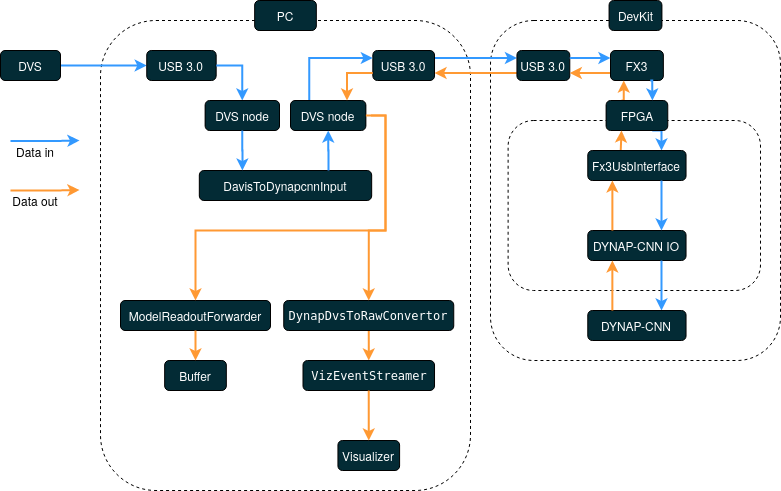
